In [34]:
import numpy as np
import pandas as pd
import warnings

data = pd.read_csv('subsegment_topics.csv')
warnings.filterwarnings('ignore')
print(data.shape)
data.head()

(20000, 3)


,topic_id,subject,body
0,2036843,Internal Vulnerability Scanner Suggestions,"<p>Hi All,</p><p>I am looking into purchasing/..."
1,2145900,"Cryptocurrencies Make Their Way to Campus, Bri...",<p>\r\n\r\nIt can be hard for college students...
2,1400878,Vulnerability with Mac iOS Gatekeeper,<p>Hackers in DC have shown that Mac iOS' Gate...
3,781618,Crypto Wall on my server.,"<p>hi everyone, </p>\n<p>I'm new here , i real..."
4,2103779,Security Audit in the South East US,<p>Good Morning and Happy 2018. </p><p>We are ...


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
topic_id    20000 non-null int64
subject     20000 non-null object
body        20000 non-null object
dtypes: int64(1), object(2)
memory usage: 468.8+ KB


# Preprocessing of data

In [36]:
import re
from bs4 import BeautifulSoup

def delete_unnecessary_symbols(data):
    
    body = data['body']
    
    new_body = []
    for el in body:
        el = BeautifulSoup(el, "html.parser").get_text()
        el = el.replace('\n','')
        el = el.replace('\t','')
        el = el.replace('\r','')
        
        new_body.append(el)
        
    data['body'] = new_body
    
    return data

new_data = delete_unnecessary_symbols(data) 



In [37]:
new_data.head()

,topic_id,subject,body
0,2036843,Internal Vulnerability Scanner Suggestions,"Hi All,I am looking into purchasing/trying a I..."
1,2145900,"Cryptocurrencies Make Their Way to Campus, Bri...",It can be hard for college students to find ti...
2,1400878,Vulnerability with Mac iOS Gatekeeper,Hackers in DC have shown that Mac iOS' Gatekee...
3,781618,Crypto Wall on my server.,"hi everyone, I'm new here , i really need some..."
4,2103779,Security Audit in the South East US,Good Morning and Happy 2018. We are looking to...


# Vectorizing of text data

I'll take not all number of objects, because first of all i want ot find the best algorithm for clustering. For saving the time during the searching the best one, I'll take not all data

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer(max_features=10000)

new_body_vec = vectorizer.fit_transform(new_data['body'])

In [39]:
new_body_vec

<20000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1568924 stored elements in Compressed Sparse Row format>

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(new_body_vec[:15000], test_size=0.2)

In [14]:
print('The size of train dataset:', X_train.shape)
print('The size of test dataset:', X_test.shape)

The size of train dataset: (4000, 10000)
The size of test dataset: (1000, 10000)


# Part 1. Clustering

So, right now we will do next: we will take 3 algorithms (KMeans, DBSCAN and ), then try to find the best number of clusters and other params for every algorithms (apart of DBSCAN, because it do this himself) and will check the accuracy of every algorithm with the help of `silhouette score`. You can check what it is in internet. All what you should know, 1 is the best clustering, -1 worst, 0 is overlapping clusters.

## KMeans

In [15]:
X_train

<4000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 310205 stored elements in Compressed Sparse Row format>

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

model = KMeans()

model.fit(X_train)
print('Silhouette score:', silhouette_score(X_train, model.labels_))

Silhouette score: -0.0016958163828391627


Try to choose the best number of clusters:

In [13]:
number_clusters = [10, 12, 14]

all_inertia = []
all_silhouettes = []
for i in number_clusters:
    model = KMeans(n_clusters=i).fit(X_train)
    all_inertia.append(np.sqrt(model.inertia_))
    all_silhouettes.append(silhouette_score(X_train, model.labels_))
    print('Trained with {0} clusters and get inertia: {1}'.format(i,np.sqrt(model.inertia_)))

Trained with 10 clusters and get inertia: 60.389681766912226
Trained with 12 clusters and get inertia: 60.30390074735129
Trained with 14 clusters and get inertia: 60.24757251964357


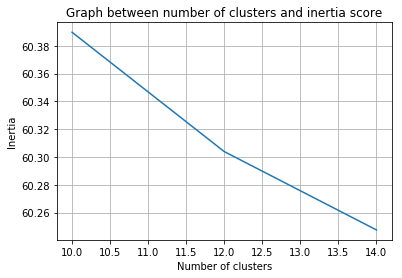

In [14]:
plt.plot(number_clusters, all_inertia)
plt.title('Graph between number of clusters and inertia score')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

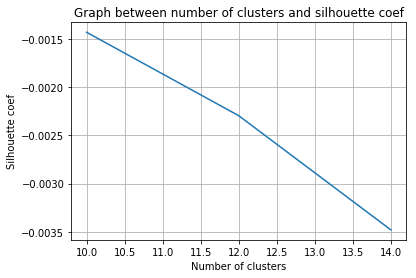

In [16]:
plt.plot(number_clusters, all_silhouettes)
plt.title('Graph between number of clusters and silhouette coef')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coef')
plt.grid()
plt.show()

So, for `KMeans` we find out, that for us the best inertia metric and silhouette coef achievs with  `12` number of clusters

## Aglomerative algorithm

In [21]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering()
agg.fit(X_train.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [25]:
print('Silhouette score:', silhouette_score(X_train, agg.labels_))

Silhouette score: -0.005300840155991942


In [28]:
number_clusters = [10, 12, 14]

all_silhouettes2 = []
for i in number_clusters:
    agg = AgglomerativeClustering(n_clusters=i).fit(X_train.toarray())
    all_silhouettes2.append(silhouette_score(X_train, agg.labels_))
    print('Trained with {0} clusters and get inertia:'.format(i))

Trained with 10 clusters and get inertia:
Trained with 12 clusters and get inertia:
Trained with 14 clusters and get inertia:


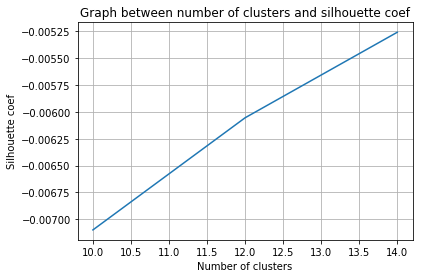

In [29]:
plt.plot(number_clusters, all_silhouettes2)
plt.title('Graph between number of clusters and silhouette coef')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coef')
plt.grid()
plt.show()

So, here we get that the best silhouette score is about `-0.005`. I can repeat that such number is not the worst clustering, it means6 that the nature of our data is too complex, the intersected, that why we get such silhouette score

## MiniBatchKMeans

In [30]:
from sklearn.cluster import MiniBatchKMeans

mini_batch_model = MiniBatchKMeans()
mini_batch_model.fit(X_train)

print('Silhouette coef:', silhouette_score(X_train, mini_batch_model.labels_))

Silhouette coef: -0.0029828425986289276


Try to find the best number of clusters:

In [31]:
number_clusters = [10,13,16,19]

all_silhouettes3 = []
for i in number_clusters:
    mini_batch = MiniBatchKMeans(n_clusters=i).fit(X_train)
    all_silhouettes3.append(silhouette_score(X_train, mini_batch.labels_))
    print('Trained with {0} clusters'.format(i))

Trained with 10 clusters
Trained with 13 clusters
Trained with 16 clusters
Trained with 19 clusters


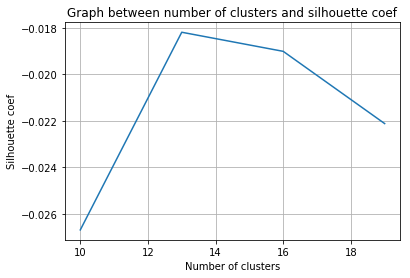

In [32]:
plt.plot(number_clusters, all_silhouettes3)
plt.title('Graph between number of clusters and silhouette coef')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coef')
plt.grid()
plt.show()

## Conclusion

So, we will check 3 algorithms and find the best one, we will use `Mini Batch KMeans` algorithm with `13` clusters for clustering our data

In [47]:
# X_train, X_test = train_test_split(new_body_vec, test_size=0.2)

vectr = CountVectorizer(max_features=15000)
train, test = train_test_split(new_data, test_size=0.2)

In [48]:
vectr.fit(train['body'])
vectr_train = vectr.transform(train['body'])
vectr_test = vectr.transform(test['body'])
print('Train:', vectr_train.shape)
print('Test:', vectr_test.shape)

Train: (16000, 15000)
Test: (4000, 15000)


In [49]:
from sklearn.cluster import MiniBatchKMeans

mini_batch_model = MiniBatchKMeans(n_clusters=13)
mini_batch_model.fit(vectr_train)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=13,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [50]:
y_train = mini_batch_model.labels_

In [52]:
train['category'] = y_train
train.head()

,topic_id,subject,body,category
13578,1981648,Ransomware without Phishing - Writeup of a Ter...,Saw this post on Reddit's r/sysadmin:https://w...,5
12691,517164,How Cryptolocker cost me 2 files...,I wish I could say that I only lost 2 files b...,4
14796,2175266,Any Success attempt in Decrypting GrandCrab 5...,I did come across article aritcles from bitdef...,12
11726,1153320,Lost Root CA. Now what?,"Hey guys, hope you're all doing well.So I was ...",0
10700,363447,SEP v12.0 install failures,I recently started an audit of our SEP system ...,8


# Part 2.Classification

In [66]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['category','topic_id', 'subject'],axis=1), train['category'], test_size=0.2)

## RandomForest

## Tuning our model

In [67]:
from catboost import CatBoostClassifier

In [96]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer


vectorizer = CountVectorizer()
vectorizer.fit(X_train['body'])
tfidf_train = vectorizer.transform(X_train['body'])
tfidf_test = vectorizer.transform(X_test['body'])

model = RandomForestClassifier()
model.fit(tfidf_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [97]:
y_pred = model.predict(tfidf_test)

In [99]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='micro')

0.6735

## SGD

In [24]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(tfidf_train, y_train)

In [112]:
y_pred = clf.predict(tfidf_test)
print('f1 score:',f1_score(y_test, y_pred, average='micro'))

f1 score: 0.85275


In [113]:
from sklearn.metrics import accuracy_score

print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.85275


## Predict and save other 5k data

In [54]:
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(vectr_train, train['category'])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [55]:
y_pred = clf.predict(vectr_test)

In [56]:
test['category'] = y_pred

In [58]:
# here I just save predicted 5k data

test.to_csv('predicted_test_data.csv', index_label=False, index=False)